In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np

# Step 1: Load dataset
data = pd.read_csv('WinnipegDataset.txt')
subset_df = data

# Verify class distribution
if subset_df['label'].nunique() < 2:
    raise ValueError("The dataset subset still contains only one class after shuffling. Check the dataset.")

# Step 2: Split data into train and test sets before scaling, PCA, and balancing
X = subset_df.drop(columns='label')
y = subset_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Data Cleaning on Training and Test Separately (Avoiding Leakage)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# Step 4.1: Multicollinearity Analysis on the Training Set Only
correlation_matrix_train = X_train.corr().abs()
upper_triangle_train = correlation_matrix_train.where(
    np.triu(np.ones(correlation_matrix_train.shape), k=1).astype(bool)
)
to_drop_train = [column for column in upper_triangle_train.columns if any(upper_triangle_train[column] > 0.9)]
X_train = X_train.drop(columns=to_drop_train)
X_test = X_test.drop(columns=to_drop_train)  # Drop the same columns from the test set

# Step 4.2: Class Balancing on the Training Set Using SMOTE with adjusted n_neighbors
smote = SMOTE(random_state=42, k_neighbors=1)  # Set n_neighbors=1 to handle small classes
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 4.3: Standardization after the split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Step 4.5: PCA after scaling and only on the training set, reduced components for speed
pca = PCA(n_components=50)  # Reduced number of components for faster computation
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Step 5: Models Training
gb = GradientBoostingClassifier(random_state=42)
lr = LogisticRegression(max_iter=500, random_state=42, class_weight='balanced')  # Reduced max_iter

# Step 6: K-Fold Cross-Validation Setup (reduced to 3 folds)
k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# Cross-validation for Gradient Boosting
gb_scores = cross_val_score(gb, X_train_pca, y_train_balanced, cv=skf, scoring='accuracy')
print(f"Gradient Boosting average accuracy over {k} folds: {gb_scores.mean():.2f}")

# Cross-validation for Logistic Regression
lr_scores = cross_val_score(lr, X_train_pca, y_train_balanced, cv=skf, scoring='accuracy')
print(f"Logistic Regression average accuracy over {k} folds: {lr_scores.mean():.2f}")

# Train models on the entire training set after cross-validation
gb.fit(X_train_pca, y_train_balanced)
lr.fit(X_train_pca, y_train_balanced)

# Step 6: Evaluate on the test set
print(f"Gradient Boosting test accuracy: {gb.score(X_test_pca, y_test):.2f}")
print(f"Logistic Regression test accuracy: {lr.score(X_test_pca, y_test):.2f}")

# Detailed Evaluation Metrics
y_pred_gb = gb.predict(X_test_pca)
y_pred_lr = lr.predict(X_test_pca)

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Gradient Boosting average accuracy over 3 folds: 0.99
Logistic Regression average accuracy over 3 folds: 0.99
Gradient Boosting test accuracy: 0.98
Logistic Regression test accuracy: 0.98

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98      7832
           2       0.94      1.00      0.97       720
           3       1.00      0.99      1.00     15135
           4       0.99      0.99      0.99     14813
           5       0.95      0.95      0.95      9423
           6       0.97      0.97      0.97     17015
           7       0.73      0.98      0.84       229

    accuracy                           0.98     65167
   macro avg       0.94      0.98      0.96     65167
weighted avg       0.98      0.98      0.98     65167


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.99      7832
           2       0

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Step 5 contd: Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 6 contd: Cross-validation for Random Forest
rf_scores = cross_val_score(rf, X_train_pca, y_train_balanced, cv=skf, scoring='accuracy')
print(f"Random Forest average accuracy over {k} folds: {rf_scores.mean():.2f}")

# Train Random Forest on the entire training set
rf.fit(X_train_pca, y_train_balanced)

# Evaluate on the test set
rf_test_accuracy = rf.score(X_test_pca, y_test)
print(f"Random Forest test accuracy: {rf_test_accuracy:.2f}")

# Detailed Evaluation Metrics for Random Forest
y_pred_rf = rf.predict(X_test_pca)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Artificial Neural Network (MLPClassifier)
# Initial layers for dimensionality reduction, followed by classification layers
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=300, random_state=42)

# Cross-validation for ANN
mlp_scores = cross_val_score(mlp, X_train_pca, y_train_balanced, cv=skf, scoring='accuracy')
print(f"ANN average accuracy over {k} folds: {mlp_scores.mean():.2f}")

# Train ANN on the entire training set
mlp.fit(X_train_pca, y_train_balanced)

# Evaluate on the test set
ann_test_accuracy = mlp.score(X_test_pca, y_test)
print(f"ANN test accuracy: {ann_test_accuracy:.2f}")

# Detailed Evaluation Metrics for ANN
y_pred_ann = mlp.predict(X_test_pca)
print("\nANN Classification Report:")
print(classification_report(y_test, y_pred_ann))


Random Forest average accuracy over 3 folds: 0.99
Random Forest test accuracy: 0.99

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      7832
           2       0.98      1.00      0.99       720
           3       1.00      1.00      1.00     15135
           4       0.99      0.99      0.99     14813
           5       0.99      0.97      0.98      9423
           6       0.99      0.99      0.99     17015
           7       0.89      0.98      0.94       229

    accuracy                           0.99     65167
   macro avg       0.98      0.99      0.98     65167
weighted avg       0.99      0.99      0.99     65167

ANN average accuracy over 3 folds: 1.00
ANN test accuracy: 1.00

ANN Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7832
           2       1.00      1.00      1.00       720
           3       1.00   

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_auc(model, X_test, y_test, model_name="Model"):
    """
    Plots the ROC-AUC curve for a given model.
    
    Parameters:
        model: Trained model object
        X_test: Test feature set
        y_test: True labels for the test set
        model_name: Name of the model (for labeling the plot)
    """
    # Check if the task is binary or multiclass
    if len(np.unique(y_test)) == 2:  # Binary classification
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f'ROC-AUC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    else:  # Multiclass classification
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        y_prob = model.predict_proba(X_test)
        n_classes = y_test_bin.shape[1]
        
        # Plotting ROC curve for each class
        plt.figure()
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')  # Corrected line
            
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f'Multiclass ROC-AUC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()


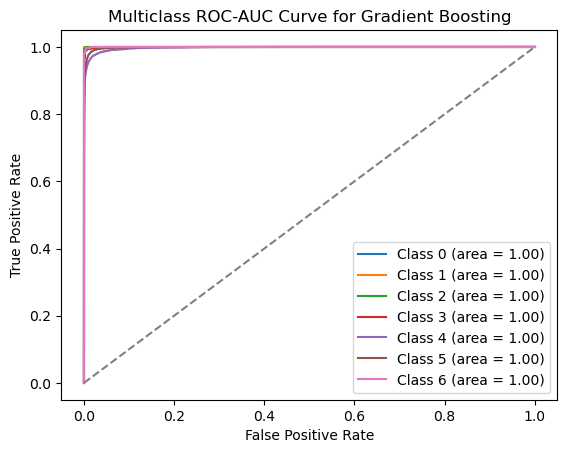

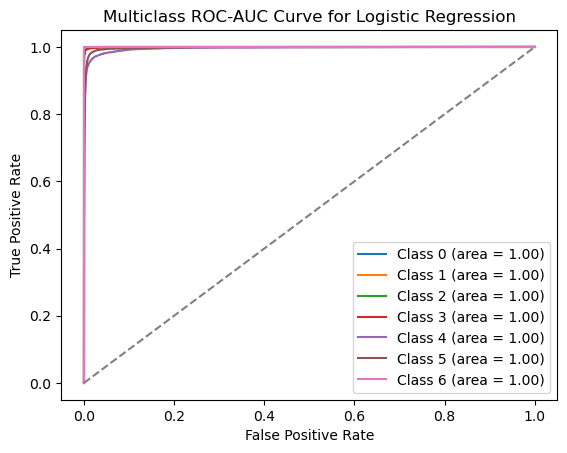

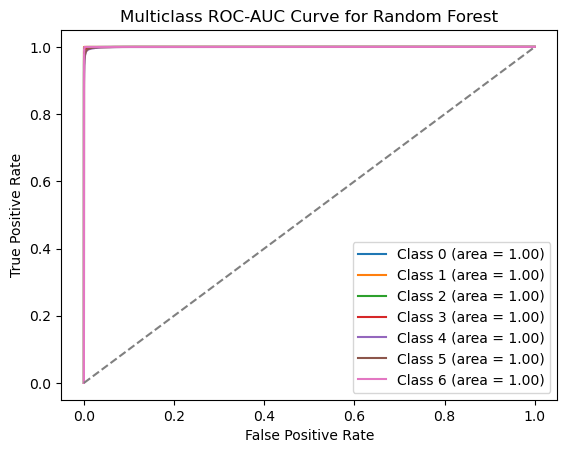

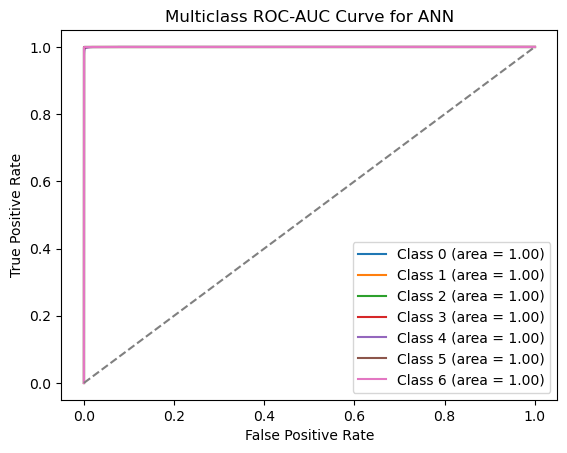

In [49]:
# Assuming gb and lr are your trained Gradient Boosting and Logistic Regression models
plot_roc_auc(gb, X_test_pca, y_test, model_name="Gradient Boosting")
plot_roc_auc(lr, X_test_pca, y_test, model_name="Logistic Regression")
plot_roc_auc(rf, X_test_pca, y_test, model_name="Random Forest")
plot_roc_auc(mlp, X_test_pca, y_test, model_name="ANN")

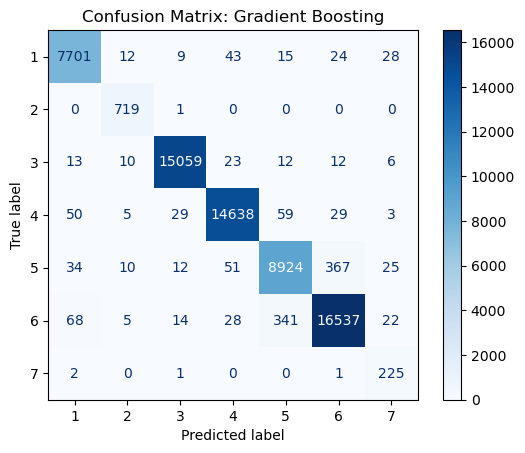

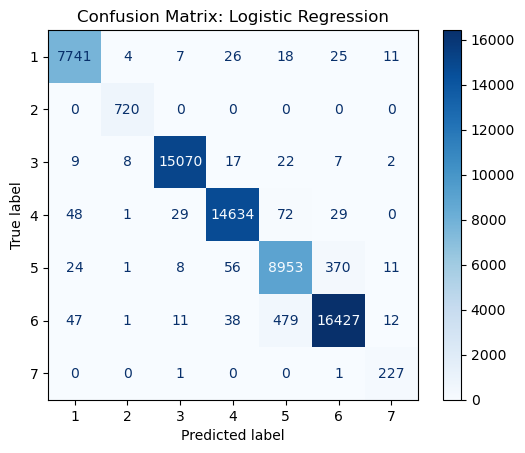

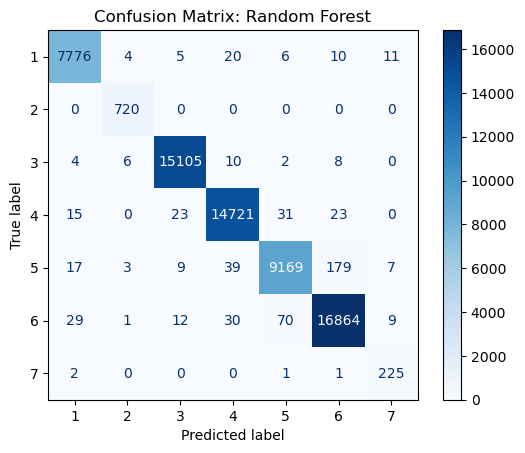

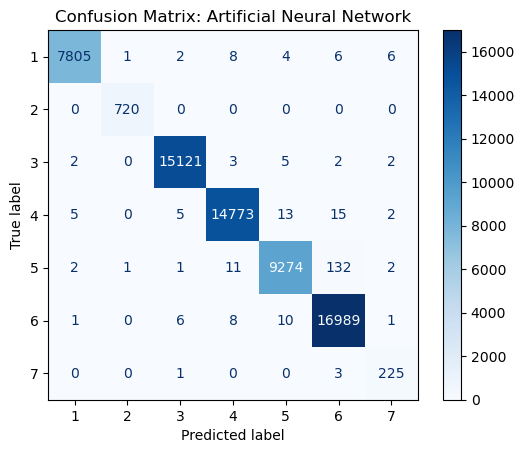

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=np.unique(y_test))
disp_gb.plot(cmap='Blues')
plt.title("Confusion Matrix: Gradient Boosting")
plt.show()

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=np.unique(y_test))
disp_lr.plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=np.unique(y_test))
disp_rf.plot(cmap='Blues')  # Corrected to use disp_rf instead of disp_lr
plt.title("Confusion Matrix: Random Forest")
plt.show()

# Confusion Matrix for ANN
cm_ann = confusion_matrix(y_test, y_pred_ann)
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=np.unique(y_test))
disp_ann.plot(cmap='Blues')
plt.title("Confusion Matrix: Artificial Neural Network")
plt.show()

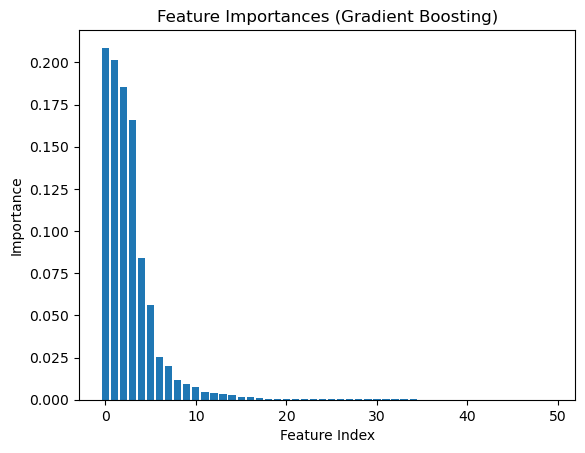

In [12]:
# Feature Importance Plot
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature Importances (Gradient Boosting)")
plt.bar(range(X_train_pca.shape[1]), importances[indices], align="center")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define parameter distributions
param_dist_gb = {
    'n_estimators': [50, 100, 150],  # Fewer estimators to reduce time
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],  # Reduced range for simplicity
    'subsample': [0.8, 1.0]  # Added subsample for faster convergence
}

# RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',
    cv=3,  # Reduced folds
    random_state=42,
    verbose=1,  # Shows progress
    n_jobs=-1  # Use all CPUs
)

# Fit RandomizedSearchCV
random_search_gb.fit(X_train_pca, y_train_balanced)

# Output best parameters and score
print("Best Parameters (Gradient Boosting):", random_search_gb.best_params_)
print("Best Cross-Validation Score:", random_search_gb.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters (Gradient Boosting): {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}
Best Cross-Validation Score: 0.9930585473464513


In [15]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('gb', gb), ('lr', lr)
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_pca, y_train_balanced)

# Evaluate the ensemble model
ensemble_accuracy = ensemble_model.score(X_test_pca, y_test)
print(f"Ensemble Model Test Accuracy: {ensemble_accuracy:.2f}")


Ensemble Model Test Accuracy: 0.98


In [61]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Matthews Correlation Coefficient
mcc_gb = matthews_corrcoef(y_test, y_pred_gb)
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)

# Cohen's Kappa
kappa_gb = cohen_kappa_score(y_test, y_pred_gb)
kappa_lr = cohen_kappa_score(y_test, y_pred_lr)
mcc_ann = matthews_corrcoef(y_test, y_pred_ann)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

# Calculate Cohen's Kappa Score for all models
kappa_ann = cohen_kappa_score(y_test, y_pred_ann)
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)

# Print the results
print(f"Matthews Correlation Coefficient (ANN): {mcc_ann:.2f}")
print(f"Matthews Correlation Coefficient (Random Forest): {mcc_rf:.2f}")
print(f"Matthews Correlation Coefficient (Gradient Boosting): {mcc_gb:.2f}")
print(f"Matthews Correlation Coefficient (Logistic Regression): {mcc_lr:.2f}")



print(f"Cohen's Kappa (ANN): {kappa_ann:.2f}")
print(f"Cohen's Kappa (Random Forest): {kappa_rf:.2f}")
print(f"Cohen's Kappa (Gradient Boosting): {kappa_gb:.2f}")
print(f"Cohen's Kappa (Logistic Regression): {kappa_lr:.2f}")


Matthews Correlation Coefficient (ANN): 0.99
Matthews Correlation Coefficient (Random Forest): 0.99
Matthews Correlation Coefficient (Gradient Boosting): 0.97
Matthews Correlation Coefficient (Logistic Regression): 0.97
Cohen's Kappa (ANN): 0.99
Cohen's Kappa (Random Forest): 0.99
Cohen's Kappa (Gradient Boosting): 0.97
Cohen's Kappa (Logistic Regression): 0.97


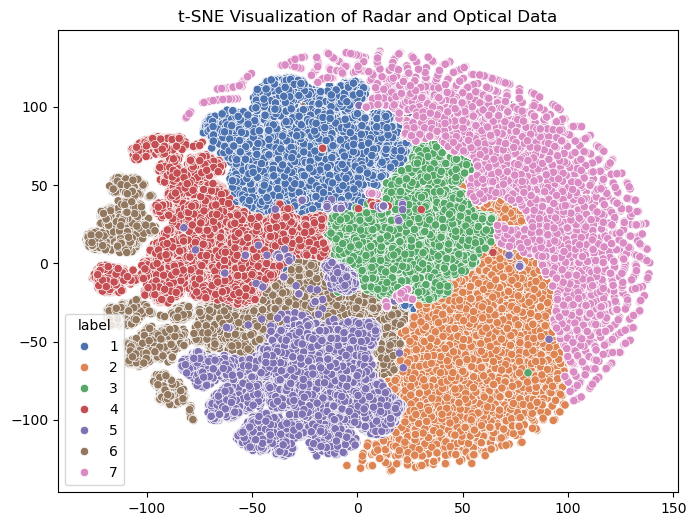

In [17]:
#Step 4.4 t-SNE
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensions to 2 for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_scaled)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train_balanced, palette="deep", legend="full")
plt.title("t-SNE Visualization of Radar and Optical Data")
plt.show()
